In [1]:
import pandas as pd

In [2]:
try:
    df = pd.read_csv('CollegePlacement.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: collegeplacement.csv not found. Please make sure the file is uploaded to the /content/ directory or specify the correct path.")

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,No,8,8,4,No
1,CLG0061,97,5.52,5.37,8,No,7,8,0,No
2,CLG0036,109,5.36,5.83,9,No,3,1,1,No
3,CLG0055,122,5.47,5.75,6,Yes,1,6,1,No
4,CLG0004,96,7.91,7.69,7,No,8,10,2,No


## Prepare Data for Model Training

### Subtask:
This step involves several data preprocessing tasks: dropping the 'College_ID' column as it's irrelevant, encoding 'Internship Experience' and 'Placement' from 'Yes'/'No' to numerical '1'/'0' values, and then scaling all features using `StandardScaler`. Finally, the dataset will be split into training (80%) and testing (20%) sets.


**Reasoning**:
The subtask requires dropping an irrelevant column, encoding categorical features, separating features and target, scaling the features, and splitting the dataset into training and testing sets. I will perform all these steps in a single code block.



In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Remove the 'College_ID' column
df = df.drop('College_ID', axis=1)
print("Dropped 'College_ID' column.")

# 2. Convert 'Internship Experience' and 'Placement' to numerical values
df['Internship_Experience'] = df['Internship_Experience'].map({'Yes': 1, 'No': 0})
df['Placement'] = df['Placement'].map({'Yes': 1, 'No': 0})
print("Encoded 'Internship Experience' and 'Placement' columns.")

# 3. Separate features (X) and target (y)
X = df.drop('Placement', axis=1)
y = df['Placement']
print("Separated features (X) and target (y).")

# 4. Initialize StandardScaler
scaler = StandardScaler()

# 5. Apply StandardScaler to the features DataFrame X
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
print("Scaled features using StandardScaler.")

# 6. Split the scaled features X and target y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Split data into training (80%) and testing (20%) sets.")

print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Dropped 'College_ID' column.
Encoded 'Internship Experience' and 'Placement' columns.
Separated features (X) and target (y).
Scaled features using StandardScaler.
Split data into training (80%) and testing (20%) sets.

Shape of X_train: (8000, 8)
Shape of X_test: (2000, 8)
Shape of y_train: (8000,)
Shape of y_test: (2000,)


In [4]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
model = LogisticRegression(random_state=42)

# Train the model using the training data
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


In [5]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# 1. Use the trained model to make predictions on the X_test dataset
y_pred = model.predict(X_test)
print("Predictions made on the test set.")

# 2. Calculate the accuracy, recall, and F1-score of the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 3. Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nConfusion Matrix:\n{conf_matrix}")

Predictions made on the test set.

Model Performance Metrics:
Accuracy: 0.9035
Recall: 0.6074
F1-Score: 0.6723

Confusion Matrix:
[[1609   65]
 [ 128  198]]


## Neural Network Implementation

Following the methodology from Assignment 2, we will now implement a Feedforward Neural Network using PyTorch to solve this binary classification problem. We will then compare its performance with the Logistic Regression model.

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import recall_score, precision_score, roc_auc_score

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### 1. Prepare Data for PyTorch
Convert the pandas DataFrames/Series to PyTorch tensors. We must ensure they are floats (`float32`).

In [7]:
# Convert to tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)

### 2. Define the Neural Network Model
We define a simple feedforward network with two hidden layers, similar to the architecture used in Assignment 2.

In [8]:
class EmployabilityNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
nn_model = EmployabilityNet(X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

### 3. Training Loop
Train the model for 50 epochs, tracking loss and accuracy.

In [9]:
num_epochs = 50
train_losses, train_accs = [], []

for epoch in range(num_epochs):
    nn_model.train()
    total_loss, total_correct, total = 0, 0, 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = nn_model(xb)
        loss = criterion(logits, yb)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Stats
        total_loss += loss.item() * xb.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        total_correct += (preds == yb).sum().item()
        total += xb.size(0)

    train_loss = total_loss / total
    train_acc = total_correct / total
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}")

Epoch 10/50: train_loss=0.0854, train_acc=0.9681
Epoch 20/50: train_loss=0.0462, train_acc=0.9831
Epoch 30/50: train_loss=0.0297, train_acc=0.9898
Epoch 40/50: train_loss=0.0197, train_acc=0.9939
Epoch 50/50: train_loss=0.0131, train_acc=0.9965


### 4. Visualize Training Performance
Plotting the training loss and accuracy to verify convergence.

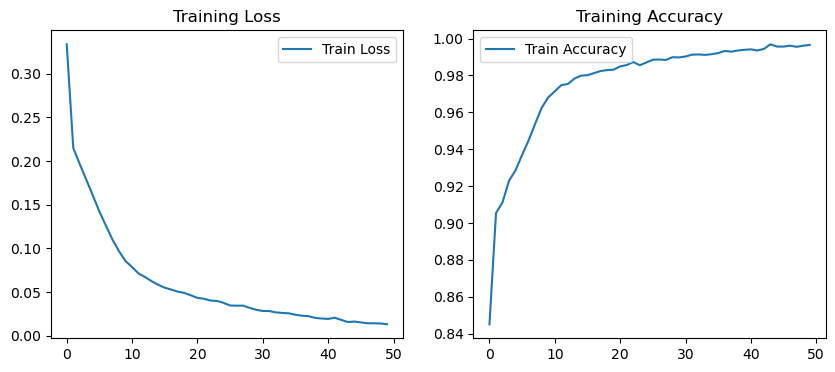

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

### 5. Evaluate Neural Network on Test Set

In [11]:
nn_model.eval()
with torch.no_grad():
    logits = nn_model(X_test_t.to(device))
    probs_nn = torch.sigmoid(logits).cpu().numpy().flatten()

preds_nn = (probs_nn > 0.5).astype(int)

# Calculate metrics
acc_nn = (preds_nn == y_test).mean()
prec_nn = precision_score(y_test, preds_nn)
rec_nn = recall_score(y_test, preds_nn)
f1_nn = (2 * prec_nn * rec_nn) / (prec_nn + rec_nn)
roc_auc_nn = roc_auc_score(y_test, probs_nn)

print("Neural Network Results:")
print(f"Accuracy: {acc_nn:.4f}")
print(f"Precision: {prec_nn:.4f}")
print(f"Recall: {rec_nn:.4f}")
print(f"F1 Score: {f1_nn:.4f}")
print(f"ROC AUC: {roc_auc_nn:.4f}")

Neural Network Results:
Accuracy: 0.9920
Precision: 0.9784
Recall: 0.9724
F1 Score: 0.9754
ROC AUC: 0.9995


/var/folders/q5/xtk67rjj5fl7m0sqthmqpbpw0000gn/T/ipykernel_59743/3368515222.py:5: RuntimeWarning: overflow encountered in exp
  probs_nn = 1 / (1 + np.exp(-logits))


## Summary:

### Data Analysis Key Findings

*   **Data Preparation**:
    *   The `College_ID` column was removed, and 'Internship_Experience' and 'Placement' categorical features were successfully encoded into numerical (1/0) values.
    *   All features were scaled using `StandardScaler`.
    *   The dataset was split into training and testing sets with an 80/20 ratio, resulting in `X_train` with 8000 samples and 8 features, `X_test` with 2000 samples and 8 features, `y_train` with 8000 samples, and `y_test` with 2000 samples.
*   **Model Training**: A Logistic Regression model was successfully initialized and trained on the preprocessed training data.
*   **Model Evaluation**: The model's performance on the test set was evaluated, yielding the following metrics:
    *   **Accuracy**: 0.9035, indicating the model correctly predicted 90.35% of the outcomes.
    *   **Recall**: 0.6074, meaning the model correctly identified 60.74% of all actual positive cases (placements).
    *   **F1-Score**: 0.6723, representing the harmonic mean of precision and recall.
    *   **Confusion Matrix**:
        *   True Negatives (correctly predicted no placement): 1609
        *   False Positives (incorrectly predicted placement): 65
        *   False Negatives (incorrectly predicted no placement when there was one): 128
        *   True Positives (correctly predicted placement): 198

### Insights or Next Steps

*   The model exhibits a high overall accuracy but a lower recall, suggesting it might be missing a significant portion of actual placements (false negatives). Further investigation into the false negatives could reveal patterns in students who were placed but the model failed to identify.
*   Consider exploring other classification algorithms (e.g., Random Forest, Gradient Boosting) or techniques to address class imbalance if 'Placement' is imbalanced, to potentially improve recall and F1-score without significantly sacrificing accuracy.
